# Pneumonia Detection From Chest X-Ray

In [1]:
!pip install -v scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Created temporary directory: /tmp/pip-ephem-wheel-cache-m0wcndug
Created temporary directory: /tmp/pip-req-tracker-kj7t_8t8
Initialized build tracking at /tmp/pip-req-tracker-kj7t_8t8
Created build tracker: /tmp/pip-req-tracker-kj7t_8t8
Entered build tracker: /tmp/pip-req-tracker-kj7t_8t8
Created temporary directory: /tmp/pip-install-dp665pln
Cleaning up...
Removed build tracker: '/tmp/pip-req-tracker-kj7t_8t8'


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve

import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import BinaryAccuracy, Precision, Recall

from keras import backend as K
from keras.models import Model
from keras.layers import *
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
80754,00019844_003.png,Atelectasis|Effusion,3,19844,56,F,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00019844_003.png
12230,00003190_000.png,No Finding,0,3190,46,F,PA,2986,2991,0.143,0.143,NaN,/data/images_002/images/00003190_000.png
110911,00030247_009.png,No Finding,9,30247,54,M,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00030247_009.png


In [4]:
# rename the data to "df"
df = all_xray_df

In [5]:
df['Patient Age'].unique()

array([ 58,  81,  74,  75,  76,  77,  78,  79,  80,  82,  69,  70,  73,
        84,  61,  60,  62,  56,  57,  71,  66,  53,  47,  48,  49,  63,
        64,  52,  68,  59,  55,  72,  67,  46,  91,  92,  87,  65,  45,
        54,  50,  51,  44,  83,  33,  42,  25,  31,  94,  89,  90,  40,
        85,  30,  32,  34,  86,  37,  27,  29,  36,  38,  39,  43,  28,
        41,  35,  22,  23,  26,  21,  88,  24,  17,  18,  19,  20,  16,
        13,  14,  11,  12,  15,  93,   9,  10,   8,   6,   7,   4,   5,
         3,   2, 412,   1, 414, 148,  95, 150, 149, 152, 151, 411, 413,
       153, 154, 155])

In [6]:
# remove patients older than 100 years old
df = df[df['Patient Age'] <= 100]
print(df.shape)

(112104, 13)


In [7]:
# find all unique diseases in the 'Finding Labels' column
all_diseases = set()

# collect unique finding labels
for x in df['Finding Labels'].unique():
    disease = x.split('|')
    for y in disease:
        all_diseases.add(y.strip())

print(all_diseases)

{'Pneumothorax', 'Cardiomegaly', 'Pleural_Thickening', 'Pneumonia', 'Edema', 'Hernia', 'No Finding', 'Effusion', 'Emphysema', 'Consolidation', 'Mass', 'Atelectasis', 'Fibrosis', 'Nodule', 'Infiltration'}


In [8]:
# create a 'pneumonia_class' column where True: with pneumonia and False: without pneumonia
df['pneumonia_class'] = df['Finding Labels'].str.contains("Pneumonia")

# convert True/False into Positive/Negative
df['pneumonia_class'] = df['pneumonia_class'].replace({True: "Positive", False: "Negative"})

# number of image that has/doesn't have pneumonia
print("Number of images with pneumonia: {}".format(sum(df['pneumonia_class'] == "Positive")))
print("Number of images without pneumonia: {}".format(sum(df['pneumonia_class'] == "Negative")))

# check df
df.head(5)

Number of images with pneumonia: 1430
Number of images without pneumonia: 110674


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png,Negative
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png,Negative
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png,Negative
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png,Negative
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png,Negative


The dataset is imbalanced. There are only 1430 images with pneumonia in the dataset (compared to 110,674 images without pneumonia). Also, we see that all these 1430 images with pneumonia come from only 1008 patients (see the cell below).

In [9]:
# number of unique patient ID in the 1431 images with pneumonia
print(df[df['pneumonia_class']=="Positive"]['Patient ID'].nunique())

1008


## Create training and validation data

In [10]:
def create_splits(df, test_size=0.33, random_state=11):
    """
    Split data into training and testing dataset
    Args:
        df: DataFrame
        test_size: ratio of the test dataset in the range [0, 1] (default=0.33)
        random_state: seed for reproducible shuffling (default=11) 
    """
    
    np.random.seed(random_state)
    
    # all patient ids
    all_patients = df['Patient ID'].unique()
    
    # patients with pneumonia iamge(s)
    pos_patients = df[df['pneumonia_class']=="Positive"]['Patient ID'].unique()
    # shuffle
    np.random.shuffle(pos_patients)
    # number of patients with pneumonia-positive image
    n_pos = len(pos_patients)
    
    # number of patients in train
    n_pos_train = int(n_pos*(1-test_size))
    n_pos_val = int(n_pos - n_pos_train)
        
    # split into train and testing
    train_ids = pos_patients[:n_pos_train]
    val_ids = pos_patients[n_pos_train:]
    
    # add pneumonia-positive images into the training and validation dataset
    train_data = df[(df['Patient ID'].isin(train_ids)) & (df['pneumonia_class']=="Positive")]
    val_data = df[(df['Patient ID'].isin(val_ids)) & (df['pneumonia_class']=="Positive")]
    
    # number of images in training/validation datasets
    n_train_data = train_data.shape[0]
    n_val_data = val_data.shape[0]
    
    # all patients who don't have pneumonia-positive images
    neg_patients = np.setdiff1d(all_patients, pos_patients)
    
    # shuffle neg_patients
    np.random.shuffle(neg_patients)
    
    # random sample n_train_data patients
    # and select the image they took on their first visit into training dataset
    neg_patients_train = neg_patients[:n_train_data]
    for pid in neg_patients_train:
        train_data = train_data.append(df[(df['Patient ID']==pid) & (df['Follow-up #']==0)])
    
    # random sample 5*n_val_data patients
    # and select the image they took on their first visit into validation dataset
    neg_patients_val = neg_patients[n_train_data: n_train_data + 5*n_val_data]
    for pid in neg_patients_val:
        val_data = val_data.append(df[(df['Patient ID']==pid) & (df['Follow-up #']==0)])
    
    return train_data, val_data

In [11]:
train_data, val_data = create_splits(df)
print("Training data: positive ratio = {:.3f}".format(sum(train_data['pneumonia_class']=="Positive")/train_data.shape[0]))
print("Testing data: positive ratio = {:.3f}".format(sum(val_data['pneumonia_class']=="Positive")/val_data.shape[0]))

Training data: positive ratio = 0.500
Testing data: positive ratio = 0.167


In [12]:
train_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,pneumonia_class
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000056_000.png,Positive
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000061_012.png,Positive
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000061_015.png,Positive
590,00000144_001.png,Pneumonia,1,144,83,M,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000144_001.png,Positive
640,00000165_001.png,Pneumonia,1,165,76,M,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000165_001.png,Positive


In [13]:
val_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000013_010.png,Positive
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000032_012.png,Positive
614,00000150_002.png,Atelectasis|Infiltration|Pneumonia,2,150,55,F,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000150_002.png,Positive
1073,00000261_002.png,Pneumonia,2,261,40,F,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000261_002.png,Positive
1078,00000261_007.png,Infiltration|Pneumonia,7,261,41,F,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000261_007.png,Positive


In [14]:
## Sanity check
# make sure we don't have data leakage
train_nunique_patients = train_data['Patient ID'].nunique()
val_nunique_patients = val_data['Patient ID'].nunique()
all_nunique_patients = train_data.append(val_data)['Patient ID'].nunique()
assert train_nunique_patients + val_nunique_patients == all_nunique_patients

## Data augmentation and image generator

In [15]:
def my_image_augmentation(train):
    """
    Create ImageDataGenerator with data augmentation for the training and test dataset
    Args:
        train: (bool) indicating whether or not the generator is for training
    Output:
        data_gen: data generator
    """
    if train:
        data_gen = ImageDataGenerator(width_shift_range=[-0.1, 0.1],
                                      height_shift_range=[-0.1, 0.1],
                                      rotation_range=10,
                                      shear_range=10,
                                      zoom_range=0.1,
                                      featurewise_center=True,
                                      featurewise_std_normalization=True)
    else:
        data_gen = ImageDataGenerator(featurewise_center=True,
                                      featurewise_std_normalization=True)
    
    
    data_gen.mean = np.array([127.5, 127.5, 127.5], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
    data_gen.std = np.array([127.5, 127.5, 127.5], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
        
    return data_gen


def make_train_gen(data_gen, df):
    """
    Implementation of the flow_from_dataframe of the traing data generator
    Args:
        data_gen - the training data generator
        df - the dataframe of the training data with paths to the images
    Outputs:
        train_gen - the training data generator
    """
    train_gen = data_gen.flow_from_dataframe(dataframe=df, 
                                             directory=None, 
                                             x_col='path',
                                             y_col='pneumonia_class',
                                             class_mode='binary',
                                             target_size=(224, 224), 
                                             batch_size=64,
                                             shuffle=True)
    return train_gen


def make_val_gen(data_gen, df):
    """
    Implementation of the flow_from_dataframe of the validation data generator
    Args:
        data_gen - the validation data generator
        df - the dataframe of the validation data with paths to the images
    Outputs:
        val_gen - the validation data generator
    """
    val_gen = data_gen.flow_from_dataframe(dataframe=df, 
                                           directory=None, 
                                           x_col='path',
                                           y_col='pneumonia_class',
                                           class_mode='binary',
                                           target_size=(224, 224), 
                                           batch_size=64,
                                           shuffle=False)
    return val_gen

## Build model

In [16]:
def build_my_model():
    """
    Build the model from Keras for image classification (using pre-trained VGG)
    """
    # create the model
    model = keras.Sequential(name='model')
    
    # load pretrained VGG16 (include_top=True)
    vgg16 = VGG16(include_top=True, weights='imagenet')
    
    # add all layers except for the last (dense) layer of vgg into model
    for vgg_layer in vgg16.layers[:-1]:
        #vgg_layer.trainable = False
        model.add(vgg_layer)
        
    # (d=4096)    
    # add a dropout layer and a final layer for binary classification
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    
    # optimizer
    opt = keras.optimizers.Adam(learning_rate=5e-5)
    
    # metrics
    metrics = [BinaryAccuracy(name='acc')]
    
    # compile
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
    
    return model

In [17]:
model = build_my_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168

## Checkpoints and callbacks

In [18]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=10)

callbacks_list = [checkpoint, early]

## Training

In [20]:
train_gen = make_train_gen(my_image_augmentation(train=True), train_data)
val_gen = make_val_gen(my_image_augmentation(train=False), val_data)

Found 1910 validated image filenames belonging to 2 classes.
Found 2850 validated image filenames belonging to 2 classes.


In [30]:
del model

model = build_my_model()

history = model.fit_generator(train_gen, 
                              validation_data = val_gen, 
                              epochs = 20, 
                              callbacks = callbacks_list)

Epoch 1/20
30/30 [==============================] - 116s 4s/step - loss: 0.9998 - acc: 0.4979 - val_loss: 0.8507 - val_acc: 0.1698

Epoch 00001: val_loss improved from inf to 0.85070, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
30/30 [==============================] - 94s 3s/step - loss: 0.6281 - acc: 0.6356 - val_loss: 0.3511 - val_acc: 0.8596

Epoch 00002: val_loss improved from 0.85070 to 0.35109, saving model to xray_class_my_model.best.hdf5
Epoch 3/20
30/30 [==============================] - 94s 3s/step - loss: 0.5490 - acc: 0.7178 - val_loss: 0.6851 - val_acc: 0.7625

Epoch 00003: val_loss did not improve from 0.35109
Epoch 4/20
30/30 [==============================] - 93s 3s/step - loss: 0.5688 - acc: 0.7073 - val_loss: 0.4520 - val_acc: 0.8326

Epoch 00004: val_loss did not improve from 0.35109
Epoch 5/20
30/30 [==============================] - 95s 3s/step - loss: 0.5361 - acc: 0.7325 - val_loss: 0.5189 - val_acc: 0.8425

Epoch 00005: val_loss did not improve from

## Model evaluation

In [21]:
# reset the validation data generator
val_gen.reset()
model.load_weights(weight_path)
pred_Y = model.predict_generator(val_gen, steps=int(np.ceil(val_gen.n/val_gen.batch_size)), verbose=1)

45/45 [==============================] - 56s 1s/step


In [22]:
# the acutal labels
y_true = np.array(val_gen.classes)
print(y_true)
print(len(y_true))

[1 1 1 ... 0 0 0]
2850


In [23]:
# predicted scores
y_score = np.squeeze(pred_Y)
print(y_score)
print(len(y_score))

[0.8348358  0.95136917 0.6688905  ... 0.08948319 0.9534876  0.28704643]
2850


In [24]:
def plot_auc(y_true, y_score):
    """
    Plot ROC curve (true positive rate - false positive rate curve)
    Args:
        y_true: true labels
        y_score: probability estimates of the positive class
    """
    # calcaulte roc
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 1)
    # plot
    ax = plt.subplot()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.show()
    return fpr, tpr, thresholds


def plot_precision_recall(y_true, y_score):
    """
    Plot precision-recall curve
    Args:
        y_true: true labels
        y_score: probability estimates of the positive class
    """
    # calculate curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_score, 1)
    # plot
    ax = plt.subplot()
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    plt.show()
    return precision, recall, thresholds
    

def plot_history(history):
    """
    Plot loss and accuracy for training epochs
    Args:
        history: the history object returned by training the model
    """
    n = len(history.history['loss'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title("Loss")
    ax1.legend(["train", "val"])
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    
    ax2.plot(history.history['acc'])
    ax2.plot(history.history['val_acc'])
    ax2.set_title("Accuracy")
    ax2.legend(["train", "val"])
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    
    plt.show()
    

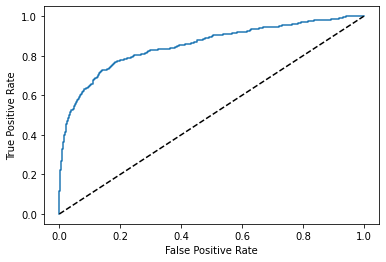

In [25]:
## plot figures
# plot ROC curve
fpr, tpr, auc_thresholds = plot_auc(y_true, y_score)

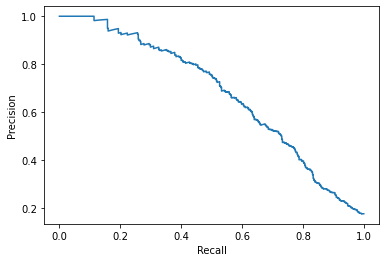

In [26]:
# plot precision-recall curve
precision, recall, pr_thresholds = plot_precision_recall(y_true, y_score)

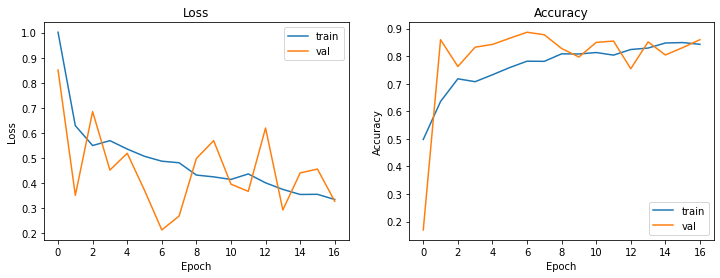

In [37]:
plot_history(history)

## Threshold Selection

The threshold is selected so that the F1 score is maximized.

F1 score is `2\*precision\*recall/(precision+recall)`

In [55]:
pr_thresholds

array([0.04969046, 0.0497382 , 0.04980564, ..., 0.99187636, 0.99378854,
       0.99458015], dtype=float32)

Threshold is chosen to be 0.2768 to maximize the F1 score 0.6197
With this threshold value, precision = 0.6184, recall = 0.6211


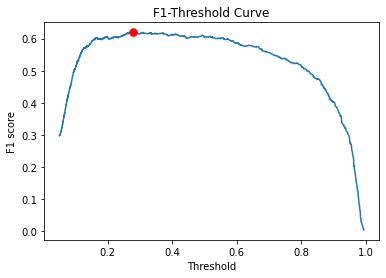

In [69]:
best_idx = None
best_f1 = -float('inf')
THRESHOLD = None

all_f1 = []
all_threshold = []

for i in range(len(precision)-1):
    # precision
    prec = precision[i]
    # recall
    rec = recall[i]
    # threshold
    thred = pr_thresholds[i]
    # calculate F1
    f1 = 2*(prec*rec)/(prec+rec)
    
    if f1 > best_f1:
        best_f1 = f1
        THRESHOLD = thred
        best_idx = i
    
    all_f1.append(f1)
    all_threshold.append(thred)

print("Threshold is chosen to be {:.4f} to maximize the F1 score {:.4f}".format(THRESHOLD, best_f1))
print("With this threshold value, precision = {:.4f}, recall = {:.4f}".format(precision[best_idx], recall[best_idx]))


# plot F1-threshold curve
ax = plt.subplot()
ax.plot(all_threshold, all_f1)
ax.plot([THRESHOLD], [best_f1], 'r.', markersize=15)
ax.set_xlabel("Threshold")
ax.set_ylabel("F1 score")
ax.set_title("F1-Threshold Curve")
plt.show()

## Some examples of predictions of the best model

I create a shullfed image generator and randomly sample a batch (n=64) images for visualizaion.

In [28]:
def make_shuffled_val_gen(data_gen, df):

    shuffled_val_gen = data_gen.flow_from_dataframe(dataframe=df, 
                                                    directory=None, 
                                                    x_col='path',
                                                    y_col='pneumonia_class',
                                                    class_mode='binary',
                                                    target_size=(224, 224), 
                                                    batch_size=64,
                                                    shuffle=True)
    return shuffled_val_gen

In [29]:
shuffled_val_gen = make_shuffled_val_gen(my_image_augmentation(train=False), val_data)

Found 2850 validated image filenames belonging to 2 classes.


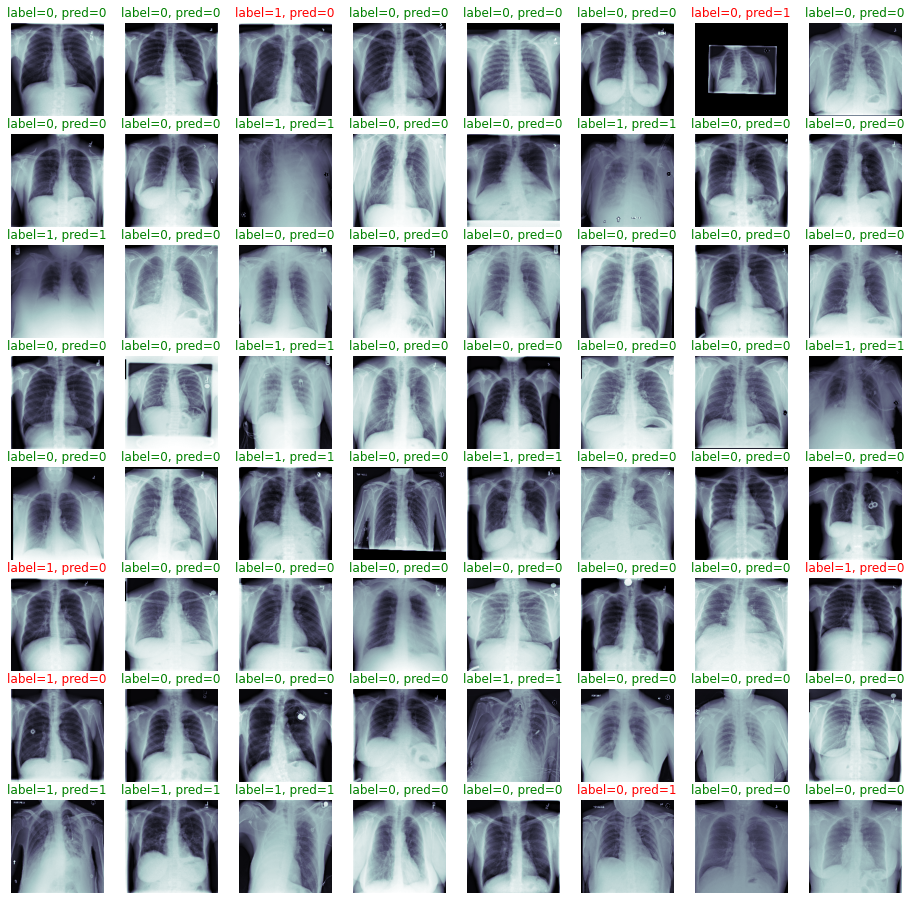

In [45]:
# reset the generator
shuffled_val_gen.reset()

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))

i = 0

# get a batch
batch_x, batch_y = next(iter(shuffled_val_gen))

batch_scores = model.predict(batch_x)

for i in range(64):
    img = batch_x[i]
    label = int(batch_y[i])
    score = batch_scores[i]
    c_ax = m_axs.flatten()[i]
    
    c_ax.imshow(img[:,:,0], cmap = 'bone')
    
    if label == 1: 
        if score > THRESHOLD:
            c_ax.set_title('label=1, pred=1', color='g')
        else:
            c_ax.set_title('label=1, pred=0', color='r')
            
    else:
        if score > THRESHOLD: 
            c_ax.set_title('label=0, pred=1', color='r')
        else:
            c_ax.set_title('label=0, pred=0', color='g')
    c_ax.axis('off')

In [46]:
# save model architecture to a .json:
model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)